In [22]:
from math import sqrt,ceil,inf
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
import networkx as nx
import pickle

In [9]:
def findball(tree, center, radius):
    """Find all nodes within distance < radius from center."""
    visited = {center}
    queue = deque([(center, 0)])
    
    while queue:
        node, dist = queue.popleft()
        if dist < radius:
            for neighbor in tree[node]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + 1))
    return visited

def compute_covering_brute(tree, r=0, burning=set(), burnt=set(), bn=inf):
    # If everything is covered
    if len(burning) == len(tree):
        return burnt, len(burnt)

    # Prune if we can't do better
    if len(burnt) >= bn:
        return set(tree.keys()), len(tree)

    best_covering = set(tree.keys())
    best_bn = bn

    to_choose = sorted(
        set(tree) - {b[0] for b in burnt},
        key=lambda node: -len(tree[node])  # sort by degree, descending
    )

    for node in to_choose:
        ball = findball(tree, node, r)
        new_burning = burning.union(ball)
        new_burnt = burnt.union({(node,r)})
        candidate_covering, candidate_bn = compute_covering_brute(tree, r + 1, new_burning, new_burnt, best_bn)

        if candidate_bn < best_bn:
            best_covering = candidate_covering
            best_bn = candidate_bn

    return best_covering, best_bn

In [10]:
def to_adjacency(nodes,edges):
    '''Takes an int nodes and list of tuples edges and return adjacency form of the tree'''
    adj = {i:[] for i in range(nodes)}
    for (x,y) in edges:
        adj[x]+= [y]
        adj[y]+= [x]
    return adj

#first initialise the offspring distribution (zeta): p_0, p_1, ... p_k
def zeta_unspecified(randweight=10, tolerance=10**(-6)):
    T = 1
    p = []
    while T > 0:
        newp = random.random()/randweight
        if T >= newp:
            T = T - newp
            p.append(newp)
        else:
            p.append(T)
            T = 0
    assert(-tolerance <= sum(p) - 1 <= tolerance)
    return p


# a zeta where the expected number of children is 1, this is called a critical GW process
zeta_critical_example1 = [0.4, 0.3, 0.2, 0.1]
zeta_critical_example2 = [0.3, 0.4, 0.3]

##########################################################################################

#next we use the previous code to make a zeta and generate a GW tree of specified size n
def generate_GW(zeta, n, seed=None):
    if seed is not None:
        random.seed(seed)
        
    kidlist = list(range(len(zeta)))  # Values 0, 1, ..., max children
    edges = set()
    parent = 0
    upper = 1  # First unused node ID
    active_nodes = [0]  # List of nodes to expand (acts like a queue)

    while active_nodes and upper < n:
        parent = active_nodes.pop(0)
        nchild = random.choices(kidlist, weights=zeta, k=1)[0]

        for _ in range(nchild):
            if upper >= n:
                return (n, edges)
            edges.add((parent, upper))
            active_nodes.append(upper)
            upper += 1

    return (upper, edges)


In [11]:

def generate_uniform_tree(n):
    """
    Generate a uniform random tree on n nodes using a random Prufer sequence.
    Nodes are labeled 0 to n-1.
    """
    if n == 1:
        return nx.Graph()  # single node tree with no edges
    
    # Generate a random Prufer sequence of length n-2
    prufer_seq = [random.randint(0, n-1) for _ in range(n-2)]
    
    # Decode Prufer sequence into a tree (list of edges)
    # Algorithm adapted from Prufer sequence decoding:
    degree = [1] * n
    for node in prufer_seq:
        degree[node] += 1
    
    edges = []
    # Find the smallest node with degree 1
    leaf = 0
    while leaf < n and degree[leaf] != 1:
        leaf += 1
    
    for node in prufer_seq:
        edges.append((leaf, node))
        degree[leaf] -= 1
        degree[node] -= 1
        
        if degree[node] == 1 and node < leaf:
            leaf = node
        else:
            leaf += 1
            while leaf < n and degree[leaf] != 1:
                leaf += 1
    
    # Add the last edge
    u, v = [i for i in range(n) if degree[i] == 1]
    edges.append((u, v))
    
    # Create and return the tree graph
    tree = nx.Graph()
    tree.add_nodes_from(range(n))
    tree.add_edges_from(edges)
    return tree

In [12]:
# Define the functions from the last cell
def plot_tree(edges):
    def get_positions(node, depth=0, pos={}, x=0, dx=1):
        if node not in pos:
            pos[node] = (x, -depth)
            children = [v for u, v in edges if u == node]
            if children:
                dx = dx / len(children)
                next_x = x - dx * (len(children) - 1) / 2
                for i, child in enumerate(children):
                    pos = get_positions(child, depth + 1, pos, next_x + i * dx, dx)
        return pos

    def draw_tree(ax, edges, pos):
        for u, v in edges:
            x_values = [pos[u][0], pos[v][0]]
            y_values = [pos[u][1], pos[v][1]]
            ax.plot(x_values, y_values, 'gray')

        for node, (x, y) in pos.items():
            ax.scatter(x, y, c='skyblue', s=100)
            ax.text(x, y, str(node), fontsize=12, ha='center', va='center')

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_axis_off()

    root = 0
    pos = get_positions(root)
    draw_tree(ax, edges, pos)

    plt.show()


In [14]:
# Execute the final cell to reproduce the error
n = 25
bn = ceil(sqrt(n))
Trees = X
print(Trees[-1])
labels = y
data_size = 1000

lambda_ = 0.92
k_values = np.arange(0, 11)
zeta = poisson.pmf(k_values, mu=lambda_)
print(zeta)
print(bn-1)
while len(Trees)<1000:
    nodes, edges = generate_GW(zeta, n)
    tree = to_adjacency(nodes,edges)
    if nodes == n and all(tree[x] != [] for x in range(n)):
        covering,best_bn = compute_covering_brute(tree)
        Trees.append(tree)
        labels.append(covering)

{0: [1], 1: [3, 0, 2], 2: [5, 4, 1], 3: [1, 6], 4: [2, 7], 5: [2, 8], 6: [11, 3, 10, 9], 7: [4], 8: [5], 9: [6], 10: [12, 6], 11: [14, 6, 16, 13, 15], 12: [10], 13: [17, 11, 18], 14: [19, 11, 20], 15: [11], 16: [11], 17: [21, 13], 18: [22, 13], 19: [14, 23], 20: [24, 14], 21: [17], 22: [18], 23: [19], 24: [20]}
[3.98519041e-01 3.66637518e-01 1.68653258e-01 5.17203325e-02
 1.18956765e-02 2.18880447e-03 3.35616686e-04 4.41096215e-05
 5.07260648e-06 5.18533107e-07 4.77050458e-08]
4


In [15]:
def graph_edges(tree):
    edges = []
    for node in tree:
        for adjacent in tree[node]:
            if (adjacent, node) not in edges:
                edges.append((node,adjacent))
    return edges
print(len(X))
with open('data.pkl', 'wb') as f:
    pickle.dump((X, y), f)

1000


[(0, 2), (0, 1), (1, 3), (2, 5), (2, 4), (5, 6), (6, 8), (6, 7), (6, 10), (6, 9), (9, 11), (9, 12), (10, 15), (10, 14), (10, 13), (11, 16), (12, 17), (13, 18), (17, 20), (17, 19), (19, 21), (20, 22), (21, 24), (21, 23)]


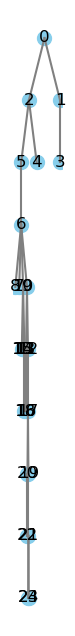

{(19, 2), (1, 1), (6, 3), (22, 0)}


In [25]:
with open('data.pkl', 'rb') as file:
    X,y = pickle.load(file)
edges = graph_edges(X[2])
print(edges)
plot_tree(edges)
print(y[2])

In [24]:
class GNN(nn.Module):
    def __init__(self,din,dh,dr,np):
        super().__init__()
        self.dh = dh
        self.din = din
        self.dr = dr
        self.np = np
        
        # Encoder:
        self.W_E = nn.Linear(din + dh, dh)
        self.b_E = nn.Parameter(din, dh)

        # Processor:
        self.W_M = 